In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
import math

from sklearn.metrics.pairwise import euclidean_distances
from matplotlib.patches import Rectangle

### One function for each step in the pipeline

In [2]:
def get_ocr_data(json_file):
    with open(json_file) as fp:
        data = json.loads(fp.read())
    
    nodes = []

    for b in data['Blocks']:
        if b['BlockType'] == 'LINE':
            node = {'text': b['Text'], 
                    'left': b['Geometry']['BoundingBox']['Left'], 
                    'top': b['Geometry']['BoundingBox']['Top'],
                    'right': b['Geometry']['BoundingBox']['Left'] + b['Geometry']['BoundingBox']['Width'],
                    'bottom': b['Geometry']['BoundingBox']['Top'] + b['Geometry']['BoundingBox']['Height'],
                   'color': ''}

            nodes.append(node)
    
    return pd.DataFrame(nodes)

In [3]:
def open_image(filename, threshold_value = 200):
    
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    threshold = 1 - (threshold / 255.)
    
    return threshold

In [4]:
def set_bounding_boxes_in_pixels(df, img):
    
    img_height = img.shape[0]
    img_width = img.shape[1]
    
    for i, row in df.iterrows():
         
        df.at[i, 'left']   = int(round(row['left'] * img_width))
        df.at[i, 'right']  = int(round(row['right'] * img_width))
        df.at[i, 'top']    = int(round(row['top'] * img_height))
        df.at[i, 'bottom'] = int(round(row['bottom'] * img_height))
        
    df['left']   = df['left'].astype(int)
    df['right']  = df['right'].astype(int)
    df['top']    = df['top'].astype(int)
    df['bottom'] = df['bottom'].astype(int)
    
    return df

In [5]:
def stamp_bounding_boxes_on_image(df, img):
    
    img_out = img.copy()

    for i, row in df.iterrows():

        img_out[ row['top']:row['bottom'], row['left']:row['right']] = 1
    
    return img_out

In [6]:
def get_filled_shapes(img):
    
    contours, tree = cv2.findContours(cv2.convertScaleAbs(img), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    img_out = np.zeros_like(img)

    for i, contour in enumerate(contours):
        cv2.drawContours(img_out, [contour], 0, (1, 1, 1), thickness=cv2.FILLED)
        
    return img_out

In [7]:
def get_masks(img, max_iter=10):
    

    kernel = np.ones((3, 3), np.uint8)

    img_eroded = [img.copy()]
    contours_iter = []

    for i in range(max_iter):
        contours, tree = cv2.findContours(cv2.convertScaleAbs(img_eroded[-1]), 
                                          cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours_iter.append(contours)
        img_eroded.append(cv2.erode(img_eroded[-1], kernel, iterations = 1))
    
    min_contours = len(contours_iter[-1])
    min_contours_iteration = len(contours_iter)-1

    for i in range(len(contours_iter)-1, -1, -1):
        if len(contours_iter[i]) > min_contours:
            min_contours_iteration = i+1
            break
            
            
    nodes_mask = img_eroded[min_contours_iteration]
    
    nodes_mask_dilated = cv2.dilate(nodes_mask, kernel, iterations=min_contours_iteration+1)
    edges_mask = np.maximum((img_eroded[0] - nodes_mask_dilated), 0)


    return nodes_mask, edges_mask

In [8]:
def get_edges(edges_mask):
    
    final_edges = []

    contours, tree = cv2.findContours(cv2.convertScaleAbs(edges_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for contour in contours:

        countour_points = contour[:,0,:]

        x_min = np.min(countour_points[:,0])
        x_max = np.max(countour_points[:,0])
        y_min = np.min(countour_points[:,1])
        y_max = np.max(countour_points[:,1])

        candidates = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]])

        minimum_distances_to_candidates = np.min(euclidean_distances(candidates, countour_points), axis=1)

        final_endpoints = candidates[np.argsort(minimum_distances_to_candidates)[:2], :]

        final_edges.append(final_endpoints)


    return np.stack(final_edges)

In [9]:
def get_connections(edges, nodes_mask, dist_threshold_percentage = 2):
    
    connections = []
    
    dist_threshold_in_pixels = int((dist_threshold_percentage / 100) * nodes_mask.shape[0])
    
    nodes_contours, tree = cv2.findContours(cv2.convertScaleAbs(nodes_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for edge in edges:

        connection = [None, None]

        for i_endpoint, endpoint in enumerate(edge):

            endpoint = np.expand_dims(endpoint, axis=0)

            min_dist_to_node = 9e3
            min_dist_node_n = -1

            for i_node, node in enumerate(nodes_contours):

                node = node[:,0,:]

                min_dist = np.min(euclidean_distances(node, endpoint).squeeze())

                if min_dist < min_dist_to_node:
                    min_dist_to_node = min_dist
                    min_dist_node_n = i_node

            if min_dist_to_node < dist_threshold_in_pixels:

                connection[i_endpoint] = min_dist_node_n

        connections.append(connection) 
    
    return pd.DataFrame(connections, columns=['node a', 'node b'])

In [10]:
def get_nodes(ocr, nodes_mask, threshold_iou = 0.8):
    
    df = ocr.copy()
    nodes_contours, tree = cv2.findContours(cv2.convertScaleAbs(nodes_mask), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    
    for i, row in df.iterrows():

        area = (row['right'] - row['left']) * (row['bottom'] - row['top'])

        max_iou = 0
        max_iou_i_node = -1
        

        for i_node, contour in enumerate(nodes_contours):

            empty_img = np.zeros_like(nodes_mask)

            cv2.drawContours(empty_img, [contour], 0, (1, 1, 1), thickness=-1)

            intersection = empty_img[row['top']:row['bottom'], row['left']:row['right']].sum()

            iou = intersection / area

            if iou > max_iou:
                max_iou = iou
                max_iou_i_node = i_node

        if max_iou > threshold_iou:

            df.at[i, 'node_id'] = max_iou_i_node
    
    return df

# sample example

In [19]:
ocr = get_ocr_data('../textract_outputs/mindmap3/analyzeDocResponse.json')


image = []


image.append(open_image('../graphs/small_mindmap3.jpg', threshold_value=200))


ocr = set_bounding_boxes_in_pixels(ocr, image[-1])

image.append(stamp_bounding_boxes_on_image(ocr, image[-1]))

image.append(get_filled_shapes(image[-1]))

nodes_mask, edges_mask = get_masks(image[-1], max_iter = 5)

image.append(nodes_mask)
image.append(edges_mask)

edges = get_edges(edges_mask)

connections = get_connections(edges, nodes_mask, dist_threshold_percentage = 2)
nodes = get_nodes(ocr, nodes_mask, threshold_iou = 0.8)

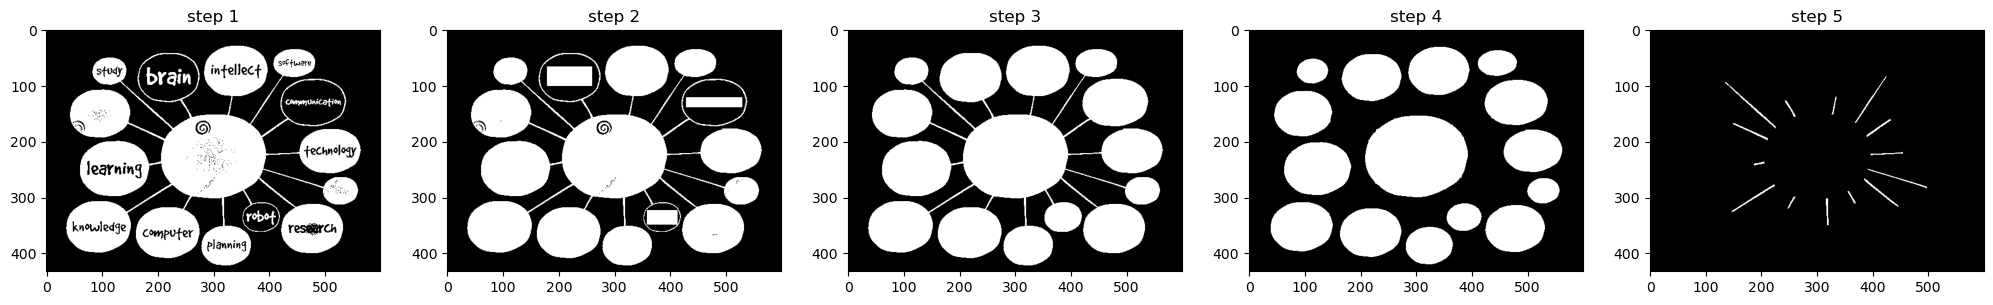

In [20]:
n_steps = len(image)

fig, ax = plt.subplots(1, n_steps, figsize=(5*n_steps, 5))

for i in range(n_steps):
    ax[i].imshow(image[i], cmap='gray')
    ax[i].set_title(f'step {i+1}')
    
plt.show()

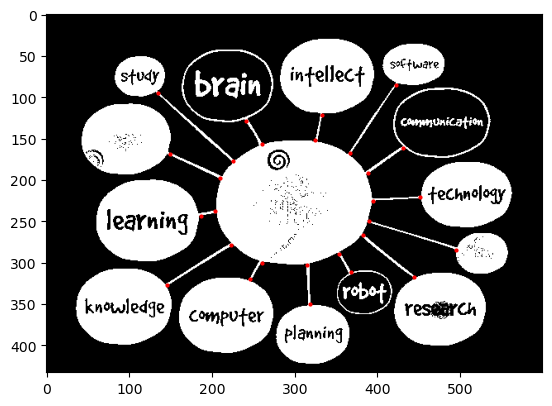

In [21]:
plt.imshow(image[0], cmap='gray')
plt.plot(edges[:, 0,0], edges[:,0,1],'ro', markersize=2)
plt.plot(edges[:, 1,0], edges[:,1,1],'ro', markersize=2)
plt.show()

In [22]:
def colordetect(hue_value):
    color_ranges = {
        (0, 5): 'RED',
        (5, 22): 'ORANGE',
        (22, 33): 'YELLOW',
        (33, 78): 'GREEN',
        (78, 151): 'BLUE',
        (151, 167): 'VIOLET',
        (167, 200): 'PINK',  
        (200, 240): 'PURPLE',  
        (240, 300): 'CYAN', 
        (300, 360): 'MAGENTA'  
    }
    
    if hue_value == 0:
        return 'BLACK'

    for range_min, range_max in color_ranges:
        if hue_value >= range_min and hue_value < range_max:
            return color_ranges[(range_min, range_max)]

    return 'UNKNOWN'




Text(0.5, 1.0, 'Original Image')

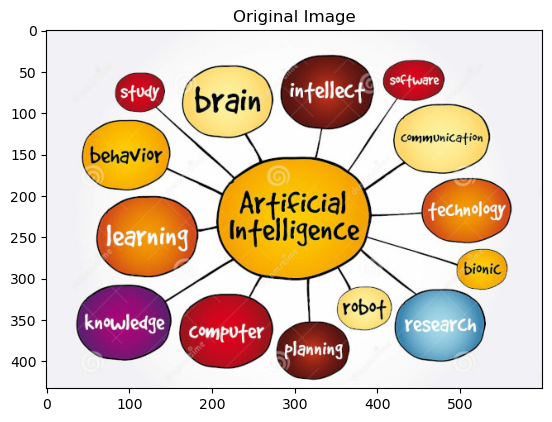

In [23]:
# read the image
image = cv2.imread('../graphs/small_mindmap3.jpg')
imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
plt.imshow(imageRGB)
plt.title('Original Image')

In [24]:
import random
from collections import Counter
image = cv2.imread("../graphs/small_mindmap3.jpg" )
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def nodes_addcolor(data, image):
    for index, row in data.iterrows():
        left = int(row["left"])
        top = int(row["top"])
        right = int(row["right"])
        bottom = int(row["bottom"])

        pixels = []
        non_zero_hue_found = False  # set boolean value

        for _ in range((right - left + 1) * (bottom - top + 1) // 2):
            x = random.randint(left, right)
            y = random.randint(top, bottom)
            color = tuple(image[y, x])
            hue_value = color[0]

            if hue_value != 0:
                pixels.append(color)
                non_zero_hue_found = True  # set True，because we find the hue_value not equal zero

        if non_zero_hue_found:
            color_counter = Counter(pixels)
            most_common_color = color_counter.most_common(1)[0][0]
        else:
            most_common_color = (0, 0, 0)  # hue = 0

        node_id = float(row["node_id"])
        data.at[index, "color"] = colordetect(most_common_color[0])
        data.at[index, "node_id"] = node_id

    return data


###In this new method, we randomly select half of the
#pixels close to the central in the specified region(bondingbox), and store the colors with non-zero hue values in the pixels list.
#Then, we use the Counter class to count the occurrence frequency of colors in the pixels list and
#select the color with the highest frequency as the color of the region.
#Finally, we update the color and node_id columns of the corresponding rows in the data DataFrame.

nodes_addcolor(nodes,image)


,text,left,top,right,bottom,color,node_id
0,software,415,52,476,70,PINK,13.0
1,study,89,65,137,87,BLUE,11.0
2,brain,179,67,260,102,GREEN,12.0
3,intellect,294,59,387,90,RED,14.0
4,communication,428,122,529,140,YELLOW,10.0
5,behavior,52,140,141,163,ORANGE,9.0
6,e,493,178,521,189,ORANGE,NaN
7,Artificial,232,192,363,231,YELLOW,8.0
8,technology,461,205,556,232,ORANGE,7.0
9,learning,72,235,172,269,ORANGE,6.0


# complex example

In [25]:
ocr = get_ocr_data('../textract_outputs/erythrocytes L1/analyzeDocResponse.json')


image = []


image.append(open_image('../graphs/erythrocytes L1 .jpg', threshold_value=200))


ocr = set_bounding_boxes_in_pixels(ocr, image[-1])

image.append(stamp_bounding_boxes_on_image(ocr, image[-1]))

image.append(get_filled_shapes(image[-1]))

nodes_mask, edges_mask = get_masks(image[-1], max_iter = 5)

image.append(nodes_mask)
image.append(edges_mask)

edges = get_edges(edges_mask)

connections = get_connections(edges, nodes_mask, dist_threshold_percentage = 2)
nodes = get_nodes(ocr, nodes_mask, threshold_iou = 0.8)

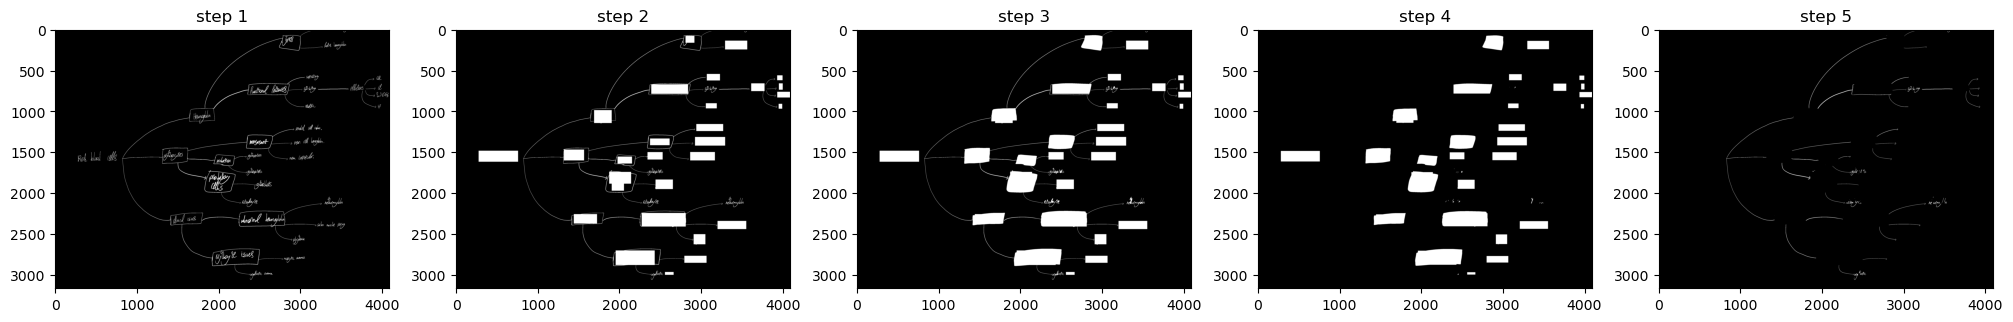

In [26]:
n_steps = len(image)

fig, ax = plt.subplots(1, n_steps, figsize=(5*n_steps, 5))

for i in range(n_steps):
    ax[i].imshow(image[i], cmap='gray')
    ax[i].set_title(f'step {i+1}')
    
plt.show()

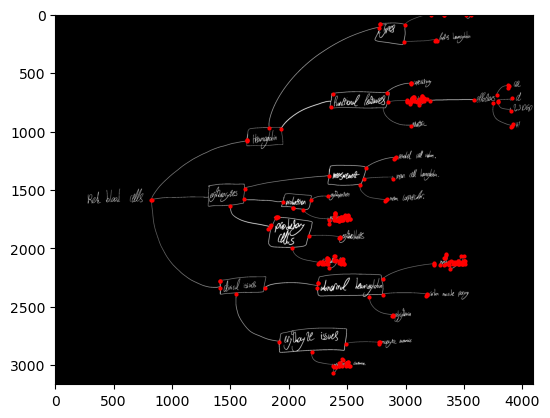

In [27]:
plt.imshow(image[0], cmap='gray')
plt.plot(edges[:, 0,0], edges[:,0,1],'ro', markersize=2)
plt.plot(edges[:, 1,0], edges[:,1,1],'ro', markersize=2)
plt.show()

In [28]:
def colordetect(hue_value):
    color_ranges = {
        (0, 5): 'RED',
        (5, 22): 'ORANGE',
        (22, 33): 'YELLOW',
        (33, 78): 'GREEN',
        (78, 151): 'BLUE',
        (151, 167): 'VIOLET',
        (167, 200): 'PINK',  
        (200, 240): 'PURPLE',  
        (240, 300): 'CYAN', 
        (300, 360): 'MAGENTA'  
    }
    
    if hue_value == 0:
        return 'BLACK'

    for range_min, range_max in color_ranges:
        if hue_value >= range_min and hue_value < range_max:
            return color_ranges[(range_min, range_max)]

    return 'UNKNOWN'




Text(0.5, 1.0, 'Original Image')

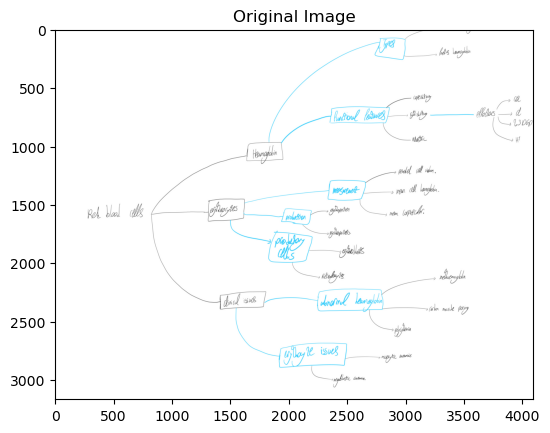

In [29]:
# read the image
image = cv2.imread("../graphs/erythrocytes L1 .jpg")
imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
 
plt.imshow(imageRGB)
plt.title('Original Image')

In [30]:
import random
from collections import Counter
image = cv2.imread("../graphs/erythrocytes L1 .jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def nodes_addcolor(data, image):
    for index, row in data.iterrows():
        left = int(row["left"])
        top = int(row["top"])
        right = int(row["right"])
        bottom = int(row["bottom"])

        pixels = []
        non_zero_hue_found = False  # set boolean value

        for _ in range((right - left + 1) * (bottom - top + 1) // 2):
            x = random.randint(left, right)
            y = random.randint(top, bottom)
            color = tuple(image[y, x])
            hue_value = color[0]

            if hue_value != 0:
                pixels.append(color)
                non_zero_hue_found = True  # set True，because we find the hue_value not equal zero

        if non_zero_hue_found:
            color_counter = Counter(pixels)
            most_common_color = color_counter.most_common(1)[0][0]
        else:
            most_common_color = (0, 0, 0)  # hue = 0

        node_id = float(row["node_id"])
        data.at[index, "color"] = colordetect(most_common_color[0])
        data.at[index, "node_id"] = node_id

    return data


###In this new method, we randomly select half of the
#pixels close to the central in the specified region(bondingbox), and store the colors with non-zero hue values in the pixels list.
#Then, we use the Counter class to count the occurrence frequency of colors in the pixels list and
#select the color with the highest frequency as the color of the region.
#Finally, we update the color and node_id columns of the corresponding rows in the data DataFrame.

nodes_addcolor(nodes,image)


,text,left,top,right,bottom,color,node_id
0,Types,2802,83,2911,168,BLUE,48.0
1,lee's Leamoglobin,3285,142,3556,250,BLACK,47.0
2,coperativity,3062,549,3223,629,BLACK,46.0
3,COL,3921,566,3987,626,BLACK,45.0
4,functional learnes,2384,676,2833,792,BLUE,44.0
5,elladors,3604,664,3767,759,BLACK,43.0
6,d,3942,664,3989,742,BLACK,42.0
7,L3DGP,3922,767,4087,837,BLACK,38.0
8,Allostric,3050,907,3184,970,BLACK,37.0
9,HT,3939,914,3983,974,BLACK,NaN


# 

# 